In [76]:
#first modelling attempt
#first create the data splits - due to skewed data, create test and train in 2 groups.  One in the low end, one in high end

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
endtrain=pd.read_csv("/home/cdsw/all_data_with_features.csv")

In [78]:
end_small=endtrain[endtrain.Target <9]
end_big=endtrain[endtrain.Target>=9]
y1=end_small[["Target"]]
X1=end_small.drop("Target", axis=1)
y2=end_big[["Target"]]
X2=end_big.drop("Target", axis=1)

print(y1.shape)
print(X1.shape)
print(y2.shape)
print(X2.shape)

print(endtrain.shape)
X_train1, X_test1,Y_train1, Y_test1 = train_test_split(X1,y1,test_size=0.3, 
                                                   random_state=428)
X_train2, X_test2,Y_train2, Y_test2 = train_test_split(X2,y2,test_size=0.3, 
                                                   random_state=428)

(70895, 1)
(70895, 57)
(566, 1)
(566, 57)
(71461, 58)


In [79]:
#Validate splits by looking at splits
check3=Y_train1.groupby(["Target"])["Target"].count().reset_index(name ='Count_Train1')
#check1.columns=["Target","Count_Train2"]
check3["Prop_CountTrain1"]=check3.Count_Train1/sum(check3.Count_Train1)
check3

,Target,Count_Train1,Prop_CountTrain1
0,-1,31,0.000625
1,0,26172,0.527385
2,1,17077,0.344114
3,2,3669,0.073933
4,3,1311,0.026418
5,4,656,0.013219
6,5,320,0.006448
7,6,187,0.003768
8,7,125,0.002519
9,8,78,0.001572


In [80]:
check4=Y_test1.groupby(["Target"])["Target"].count().reset_index(name="Count_Test2")
check4["Prop_CountTest2"]=check4.Count_Test2/sum(check4.Count_Test2)
check4

,Target,Count_Test2,Prop_CountTest2
0,-2,1,0.000047
1,-1,13,0.000611
2,0,11235,0.528234
3,1,7303,0.343364
4,2,1617,0.076026
5,3,542,0.025483
6,4,233,0.010955
7,5,149,0.007006
8,6,87,0.004090
9,7,58,0.002727


In [81]:
X_train=pd.concat([X_train1, X_train2])
X_test=pd.concat([X_test1,X_test2])
Y_train=pd.concat([Y_train1,Y_train2])
Y_test=pd.concat([Y_test1,Y_test2])

In [82]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(50022, 57)
(21439, 57)
(50022, 1)
(21439, 1)


In [83]:
#reduce to the last year of data to see if can get a better read - also appeared to have some off variables
X_train3=X_train.drop(X_train.iloc[:,0:23],axis=1)
X_test3=X_test.drop(X_test.iloc[:,0:23],axis=1)

In [84]:
# Instantiate model with 1000 decision trees & minimum 5 leafs
rf2 = RandomForestRegressor(n_estimators = 1000, min_samples_leaf=5,random_state = 42)
# Train the model on training data
rf2.fit(X_train3, Y_train.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [85]:
#Create a view to be able to see the differences in performance & evaluate the RMSE
compare=Y_test
compare.reset_index(drop=True,inplace=True)

yhat2=pd.Series(rf2.predict(X_test3))
compare["preds2"]=round(yhat2,0).astype("int64")
#There is a lot which hasnot been sold in many months - will predict zeros for these
adds=pd.DataFrame({"Target": np.repeat(0,105787),"preds2" : np.repeat(0,105787)})

compare2=pd.concat([compare, adds],axis=0)
print("Pure RMSE based only on present data:", mean_squared_error(compare.Target,compare.preds2)**0.5)
print("RMSE with assumed 0's of long absent data:",mean_squared_error(compare2.Target, compare2.preds2)**0.5)

Pure RMSE based only on present data: 2.224890469147072
RMSE with assumed 0's of long absent data: 0.9133199857215228


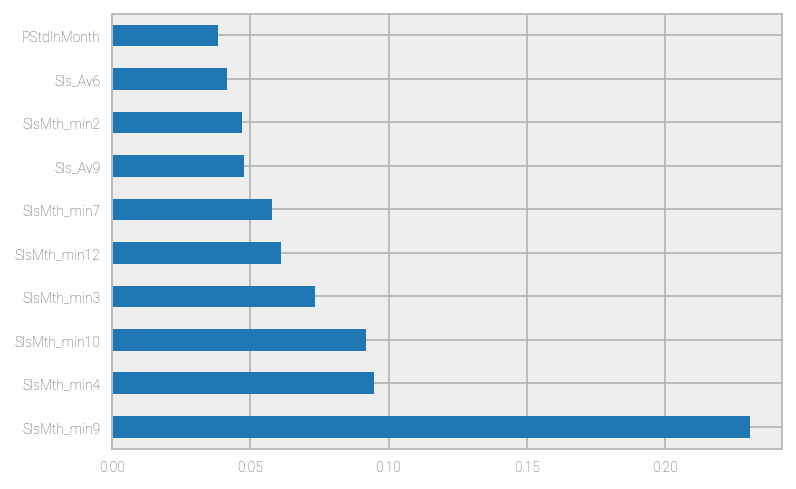

In [86]:
#This would get me top 1000,or top 25%
feat_importances = pd.Series(rf2.feature_importances_, index=X_train3.columns)
feat_importances.nlargest(10).plot(kind='barh')

#this chart is a little werid. I have the feeling that its basically saying, sales were 0 or one before... look at & understand
#am I adding too much complication where so many are 1 or 0... seperate models?

In [87]:
with open('/home/cdsw/Models/rf_red_1000_min5_v2', 'wb') as f:
    pickle.dump(rf2, f)

In [88]:
#evaluate the model in same way, get var importance: post in Kaggle